# Tech Challenge - Modelo preditivo do fechamento da IBOVESPA

## Objetivo

Analisar modelos preditivos da série temporal dos preços de fechamento da IBOVESPA, utilizando diferentes algoritmos.

##### Grupo 46

Integrantes: 

* Alexandre Aquiles Sipriano da Silva (alexandre.aquiles@alura.com.br)
* Gabriel Machado Costa (gabrielmachado2211@gmail.com)
* Caio Martins Borges (caio.borges@bb.com.br)
        

# Importando e tratando os dados

In [1]:
!pip install numpy pandas seaborn matplotlib statsmodels statsforecast scikit-learn prophet xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

# ferramentas de análise exploratória
from statsforecast import StatsForecast
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats

# métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# modelos
from statsmodels.tsa.arima.model import ARIMA
from statsforecast.models import AutoARIMA
from prophet import Prophet
import xgboost as xgb
from statsmodels.tsa.statespace.sarimax import SARIMAX

from prophet.plot import plot_plotly as prophet_plot

In [3]:
url = "https://raw.githubusercontent.com/alexandreaquiles/postech-fiap-dtat-tech-challenge-fase2/main/dados_ibovespa.csv"

In [4]:
# Carregando os dados do arquivo CSV
df = pd.read_csv(url, sep=',', thousands='.', parse_dates=[0], date_format='%d.%m.%Y')
df

Data  Último  Abertura  Máxima  Mínima     Vol.    Var%
0    2024-07-22  127860    127616  128151  127456    6,10B   0,19%
1    2024-07-19  127616    127652  128360  127413    7,62B  -0,03%
2    2024-07-18  127652    129450  129454  127523    7,59B  -1,39%
3    2024-07-17  129450    129112  129658  128741    6,67B   0,26%
4    2024-07-16  129110    129322  129521  128761    6,82B  -0,16%
...         ...     ...       ...     ...     ...      ...     ...
4948 2004-07-28   22168     21740   22213   21613  285,65M   1,98%
4949 2004-07-27   21737     21325   21813   21236  282,56M   1,97%
4950 2004-07-26   21318     21635   21930   21056  227,13M  -1,26%
4951 2004-07-23   21591     21729   22100   21559  318,00M  -0,64%
4952 2004-07-22   21730     21821   21938   21490  247,83M  -0,37%

[4953 rows x 7 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Data      4953 non-null   datetime64[ns]
 1   Último    4953 non-null   int64         
 2   Abertura  4953 non-null   int64         
 3   Máxima    4953 non-null   int64         
 4   Mínima    4953 non-null   int64         
 5   Vol.      4952 non-null   object        
 6   Var%      4953 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 271.0+ KB


In [6]:
# Lista de nomes das colunas desejados
column_names = ['data', 'fechamento','abertura', 'maxima', 'minima', 'volume', 'variacao']

# Renomeando as colunas
df.columns = column_names
df.head()

data  fechamento  abertura  maxima  minima volume variacao
0 2024-07-22      127860    127616  128151  127456  6,10B    0,19%
1 2024-07-19      127616    127652  128360  127413  7,62B   -0,03%
2 2024-07-18      127652    129450  129454  127523  7,59B   -1,39%
3 2024-07-17      129450    129112  129658  128741  6,67B    0,26%
4 2024-07-16      129110    129322  129521  128761  6,82B   -0,16%

In [7]:
# Tratando volume - removendo letras e substituir vírgula por ponto
df['volume'] = df['volume'].str.replace('B', 'e9').str.replace('M', 'e6').str.replace('K','e3').str.replace(',', '.')

# Convertendo para numérico
df['volume'] = pd.to_numeric(df['volume'])

df.head()

data  fechamento  abertura  maxima  minima        volume variacao
0 2024-07-22      127860    127616  128151  127456  6.100000e+09    0,19%
1 2024-07-19      127616    127652  128360  127413  7.620000e+09   -0,03%
2 2024-07-18      127652    129450  129454  127523  7.590000e+09   -1,39%
3 2024-07-17      129450    129112  129658  128741  6.670000e+09    0,26%
4 2024-07-16      129110    129322  129521  128761  6.820000e+09   -0,16%

In [8]:
# Tratando variação - Removendo o símbolo de porcentagem e converter para float
df['variacao'] = df['variacao'].str.replace('%', '').str.replace(',', '.').astype(float)

df.head()

data  fechamento  abertura  maxima  minima        volume  variacao
0 2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19
1 2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
2 2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
3 2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
4 2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16

In [9]:
# Ordenando os dados pela data em ordem crescrente
df = df.sort_values('data').reset_index(drop=True)
df.head()

data  fechamento  abertura  maxima  minima       volume  variacao
0 2004-07-22       21730     21821   21938   21490  247830000.0     -0.37
1 2004-07-23       21591     21729   22100   21559  318000000.0     -0.64
2 2004-07-26       21318     21635   21930   21056  227130000.0     -1.26
3 2004-07-27       21737     21325   21813   21236  282560000.0      1.97
4 2004-07-28       22168     21740   22213   21613  285650000.0      1.98

In [10]:
df.tail()

data  fechamento  abertura  maxima  minima        volume  variacao
4948 2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16
4949 2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
4950 2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
4951 2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
4952 2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4953 entries, 0 to 4952
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   data        4953 non-null   datetime64[ns]
 1   fechamento  4953 non-null   int64         
 2   abertura    4953 non-null   int64         
 3   maxima      4953 non-null   int64         
 4   minima      4953 non-null   int64         
 5   volume      4952 non-null   float64       
 6   variacao    4953 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 271.0 KB


In [12]:
# convertendo data em índice
df = df.set_index('data')

df.head()

fechamento  abertura  maxima  minima       volume  variacao
data                                                                   
2004-07-22       21730     21821   21938   21490  247830000.0     -0.37
2004-07-23       21591     21729   22100   21559  318000000.0     -0.64
2004-07-26       21318     21635   21930   21056  227130000.0     -1.26
2004-07-27       21737     21325   21813   21236  282560000.0      1.97
2004-07-28       22168     21740   22213   21613  285650000.0      1.98

In [13]:
# Filtrando os dados
start_date = pd.to_datetime('2021-07-22')  # Data a partir da qual queremos as previsões

df = df[df.index >= start_date]
df

fechamento  abertura  maxima  minima        volume  variacao
data                                                                    
2021-07-22      126147    125930  126428  125416  6.480000e+06      0.17
2021-07-23      125053    126140  126204  124422  6.050000e+06     -0.87
2021-07-26      126004    125058  126214  125006  6.330000e+06      0.76
2021-07-27      124612    126004  126026  123670  7.310000e+06     -1.10
2021-07-28      126286    124615  126712  124542  9.040000e+06      1.34
...                ...       ...     ...     ...           ...       ...
2024-07-16      129110    129322  129521  128761  6.820000e+09     -0.16
2024-07-17      129450    129112  129658  128741  6.670000e+09      0.26
2024-07-18      127652    129450  129454  127523  7.590000e+09     -1.39
2024-07-19      127616    127652  128360  127413  7.620000e+09     -0.03
2024-07-22      127860    127616  128151  127456  6.100000e+09      0.19

[749 rows x 6 columns]

# Análise Exploratória dos Dados

## Passo 1: Visualização dos dados

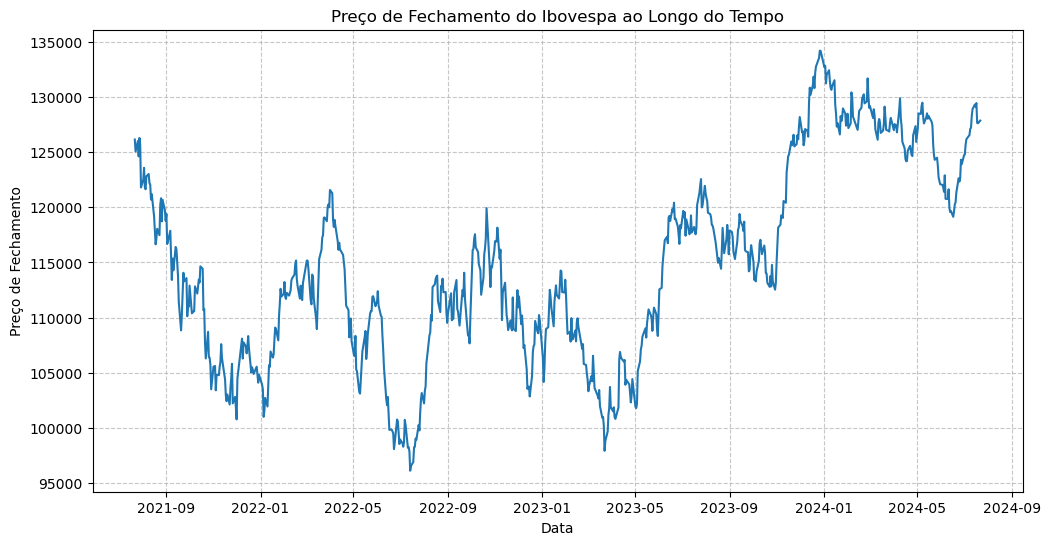

In [14]:
# Gráfico de linha do preço de fechamento ao longo do tempo

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['fechamento'], linestyle='-')
plt.title('Preço de Fechamento do Ibovespa ao Longo do Tempo')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.grid(alpha=0.7, linestyle='--')
plt.show()

### Visualização das estatísticas rolantes

In [15]:
# Estatísticas rolantes
rolmean = df['fechamento'].rolling(window=12).mean()
rolstd = df['fechamento'].rolling(window=12).std()

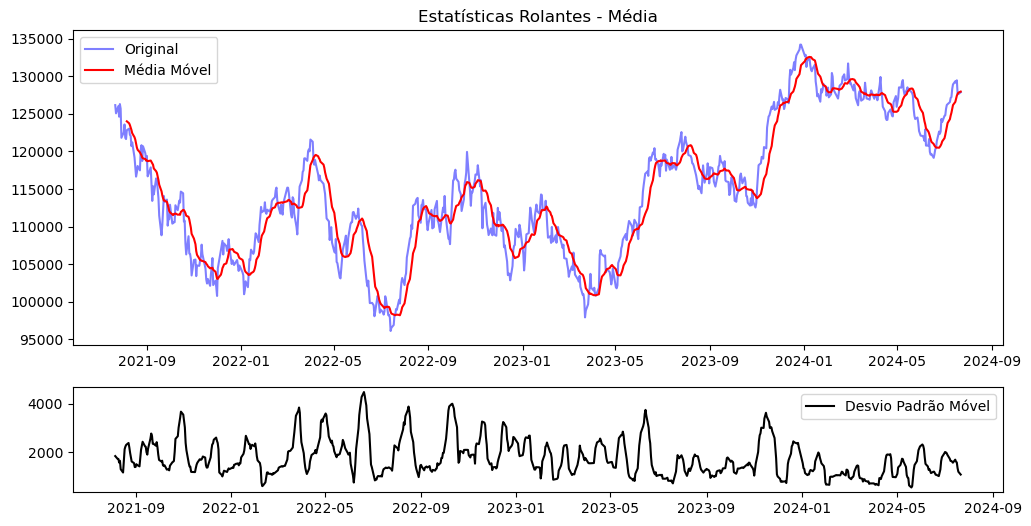

In [16]:
# Plot das estatísticas rolantes
fig = plt.figure(figsize=(12, 6))

gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])

ax1 = fig.add_subplot(gs[0])
ax1.plot(df['fechamento'], color='blue', label='Original', alpha=0.5)
ax1.plot(rolmean, color='red', label='Média Móvel')
ax1.legend(loc='best')
ax1.set_title('Estatísticas Rolantes - Média')

ax2 = fig.add_subplot(gs[1])
ax2.plot(rolstd, color='black', label='Desvio Padrão Móvel')
ax2.legend(loc='best')

plt.show()

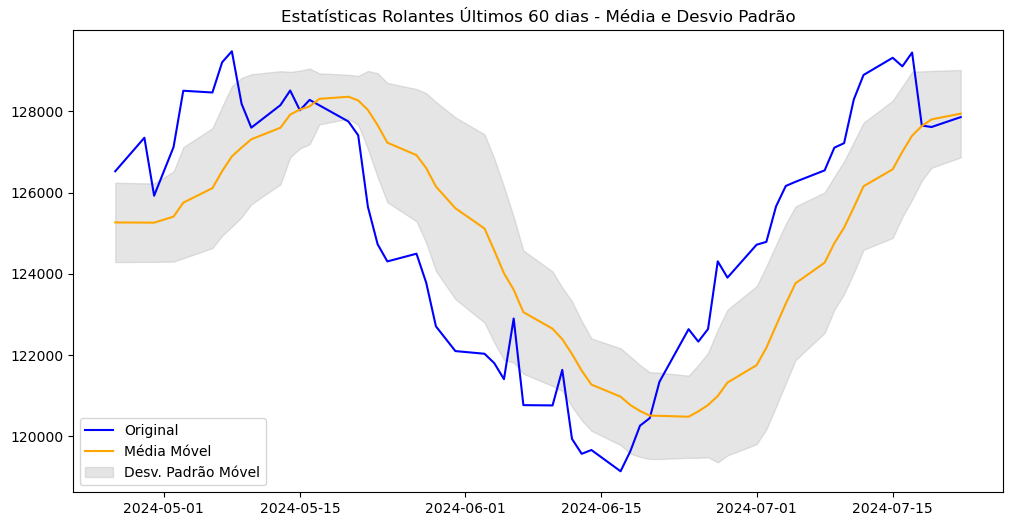

In [17]:
# Estatísticas Rolantes Últimos 60 dias

recent_days = 60

df_recent = df['fechamento'][-recent_days:]
rolmean_recent = rolmean[-recent_days:]
rolstd_recent = rolstd[-recent_days:]

# Plot das estatísticas rolantes últimos 60 dias
plt.figure(figsize=(12, 6))
plt.plot(df_recent, color='blue', label='Original')
plt.plot(rolmean_recent, color='orange', label='Média Móvel')
plt.fill_between(df_recent.index, (rolmean_recent - rolstd_recent), (rolmean_recent + rolstd_recent), color='gray', alpha=0.2, label='Desv. Padrão Móvel')

plt.legend(loc='best')
plt.title('Estatísticas Rolantes Últimos 60 dias - Média e Desvio Padrão')
plt.show()

### Decomposição da Série Temporal

In [18]:
timeseries_decompose = seasonal_decompose(df['fechamento'], model='additive', period=30)  # Exemplo de período sazonal de 30 dias

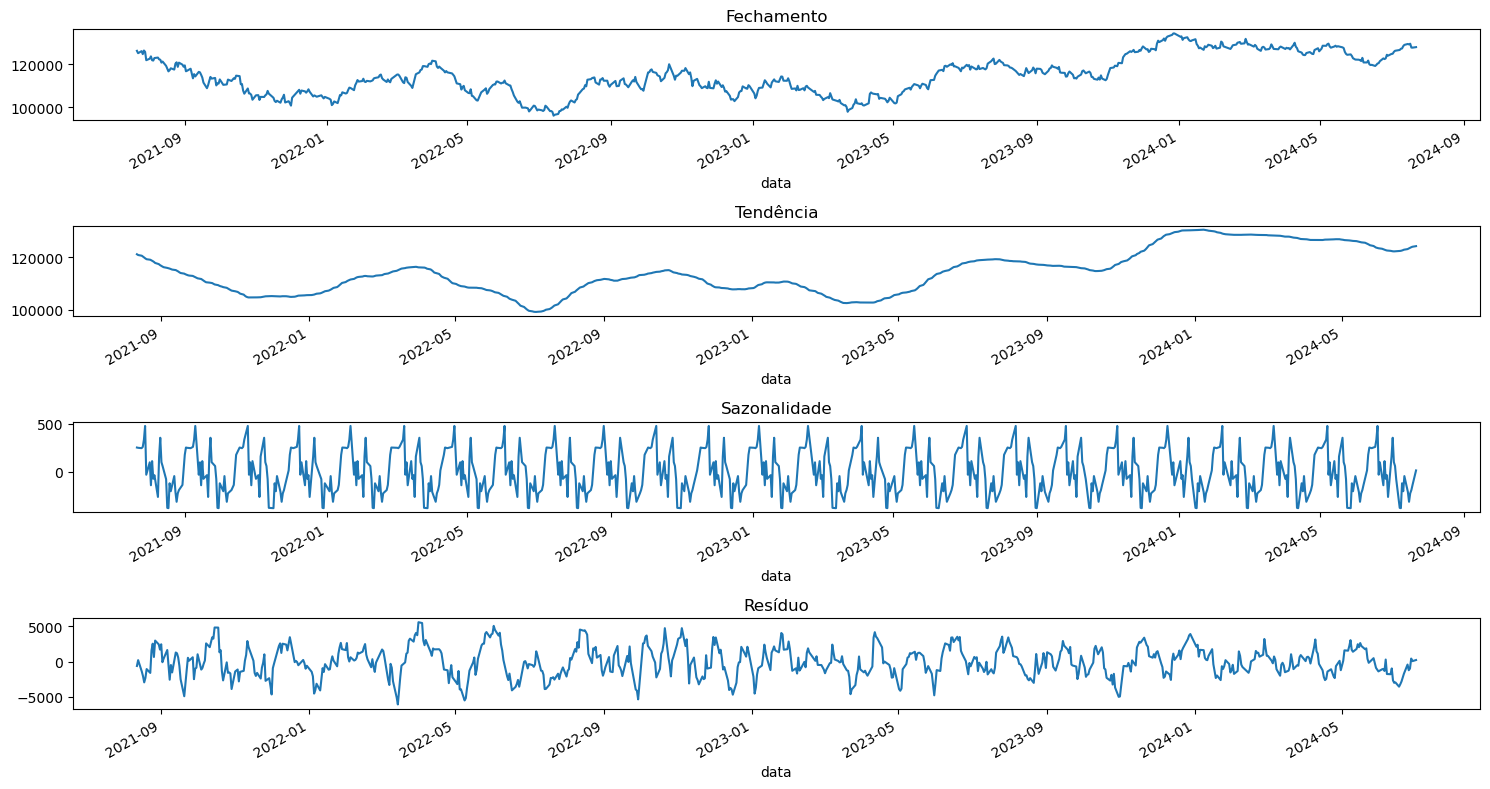

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))

timeseries_decompose.observed.plot(ax = ax1, title='Fechamento')

#tendencia
timeseries_decompose.trend.plot(ax = ax2, title='Tendência')

#sazonalidade
timeseries_decompose.seasonal.plot(ax = ax3, title='Sazonalidade')

#residuo dos dados
timeseries_decompose.resid.plot(ax = ax4, title='Resíduo')

plt.tight_layout()

## Passo 2: Testes de estacionariedade e sazonalidade

### Teste de Estacionariedade

In [20]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
df_adftest = adfuller(df['fechamento'], autolag='AIC')
dfoutput = pd.Series(df_adftest[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in df_adftest[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if df_adftest[1] > 0.05:
    print("H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)")
else:
    print("H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste             -1.972615
Valor-p                           0.298708
Número de Lags Usados             0.000000
Número de Observações Usadas    748.000000
Valor Crítico (1%)               -3.439123
Valor Crítico (5%)               -2.865412
Valor Crítico (10%)              -2.568832
dtype: float64
H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)


### Teste de Sazonalidade

In [21]:
#TESTE DE SAZONALIDADE

# Separar os dados por períodos sazonais
groups = [group[1]['fechamento'].values for group in df.groupby(df.index.month)]

# Aplicar o teste de Fisher
statistic, p= stats.f_oneway(*groups)

# Imprimir o valor-p
print(f'Valor-p do teste de Fisher: {p:.4f}')

if p > 0.05:
  print("Não há evidencia suficiente para rejeitar a hipotese de sazonalidade")
else:
  print("A hipotese de sazonalidade é rejeitada")

Valor-p do teste de Fisher: 0.3094
Não há evidencia suficiente para rejeitar a hipotese de sazonalidade


### Análise dos Resultados

- Estatística do Teste (ADF): -1.222467

A estatística do teste de Dickey-Fuller é significativamente maior que os valores críticos em todos os níveis de significância (1%, 5%, 10%). Isso indica que não temos evidências estatísticas suficientes para rejeitar a hipótese nula de que a série possui uma raiz unitária, ou seja, podemos considerar a série como não estacionária, ou seja, apresenta tendências claras, sazonalidades ou variações que dependam do tempo.

- Valor-p: 0.68

O valor-p é não é pequeno (0.68), ou seja, 68% significativamente maior que qualquer nível de significância comum, algo em torno de 5% (0.05). Isso reforça ainda mais a conclusão de que a série não é estacionária.

#### Conclusão

Com base nos resultados do teste, podemos concluir que a série temporal do preço de fechamento do Ibovespa não é estacionária. A estatística do teste de ADF é maior que os valores críticos correspondentes e o valor-p alto, comparado com o nivel de signficancia comum (5%), indicando que há raiz unitária na série e que ela não é estacionária.

Portanto, podemos **proceder com confiança para modelagem e previsão usando métodos adequados para séries temporais como ARIMA** por exemplo.

# Predição

## Passo 1: Preparação dos Dados e Modelagem

In [22]:
df_modeling = df[['fechamento', 'abertura']]
df_modeling

fechamento  abertura
data                            
2021-07-22      126147    125930
2021-07-23      125053    126140
2021-07-26      126004    125058
2021-07-27      124612    126004
2021-07-28      126286    124615
...                ...       ...
2024-07-16      129110    129322
2024-07-17      129450    129112
2024-07-18      127652    129450
2024-07-19      127616    127652
2024-07-22      127860    127616

[749 rows x 2 columns]

In [23]:
df_modeling.shape

(749, 2)

In [24]:
## Dividindo dados em treino e teste

test_size = 30
train_size = df_modeling.shape[0] - test_size
train = df_modeling[:train_size]
test = df_modeling[train_size:]

In [25]:
train

fechamento  abertura
data                            
2021-07-22      126147    125930
2021-07-23      125053    126140
2021-07-26      126004    125058
2021-07-27      124612    126004
2021-07-28      126286    124615
...                ...       ...
2024-06-04      121802    122032
2024-06-05      121407    121803
2024-06-06      122899    121408
2024-06-07      120767    122899
2024-06-10      120760    120769

[719 rows x 2 columns]

In [26]:
test.head()

fechamento  abertura
data                            
2024-06-11      121635    120760
2024-06-12      119936    121644
2024-06-13      119568    119936
2024-06-14      119662    119558
2024-06-17      119138    119663

In [27]:
test.tail()

fechamento  abertura
data                            
2024-07-16      129110    129322
2024-07-17      129450    129112
2024-07-18      127652    129450
2024-07-19      127616    127652
2024-07-22      127860    127616

In [28]:
train.shape

(719, 2)

In [29]:
test.shape

(30, 2)

## Passo 2: Métricas de avaliação dos modelos

In [30]:
# Funções de Avaliação
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, mse, mape


def print_metrics(model, metrics):
    mae, mse, mape = metrics
    print(f'{model} Metrics:')
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape}")

## Passo 3: Treinando e avaliando modelos

### ARIMA

In [31]:
# Preparando dados de treino para ARIMA
train_arima = train[['fechamento']].copy()
train_arima.tail()

fechamento
data                  
2024-06-04      121802
2024-06-05      121407
2024-06-06      122899
2024-06-07      120767
2024-06-10      120760

In [32]:
# Preparando dados de teste para ARIMA
test_arima = test[['fechamento']].copy()
test_arima.head()

fechamento
data                  
2024-06-11      121635
2024-06-12      119936
2024-06-13      119568
2024-06-14      119662
2024-06-17      119138

In [33]:
# Ajustando o modelo ARIMA
model_arima = ARIMA(train_arima, order=(5, 1, 0))

model_arima_fit = model_arima.fit()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


#### Warning: falta de frequency information nos índices no ARIMA

Ao executar o modelo ARIMA da biblioteca _statsmodels_ recebemos o seguinte warning:

> ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

Faltam informações de frequência no `DateTimeIndex` do dataframe de treino.

Tentamos resolver o problema considerando dias úteis (_business days_) na frequência com o seguinte código:

```python
test_arima = test_arima.asfreq('B') 
```

Porém, ao consideramos essa frequência, passamos a ter valores `NaN` na coluna de fechamento, devido aos feriados. Precisaríamos, definir também os feriados nacionais (ex.: 01/Mai de cada ano). O resultado das métricas do modelo ARIMA não foram modificadas significamente com essa informação. Por isso, resolvemos voltar atrás, não definindo a frequência do  `DateTimeIndex` e deixando o warning.

In [34]:
# Fazendo previsões
predict_arima = model_arima_fit.predict(start=len(train_arima), end=len(train_arima) + len(test_arima) - 1)
predict_arima

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


719    120738.729532
720    120781.294161
721    120735.834039
722    120764.672141
723    120763.737493
724    120765.029821
725    120763.649287
726    120764.617986
727    120764.201073
728    120764.247859
729    120764.203916
730    120764.238019
731    120764.219393
732    120764.226128
733    120764.224562
734    120764.225752
735    120764.225003
736    120764.225354
737    120764.225230
738    120764.225274
739    120764.225245
740    120764.225261
741    120764.225254
742    120764.225257
743    120764.225255
744    120764.225256
745    120764.225256
746    120764.225256
747    120764.225256
748    120764.225256
Name: predicted_mean, dtype: float64

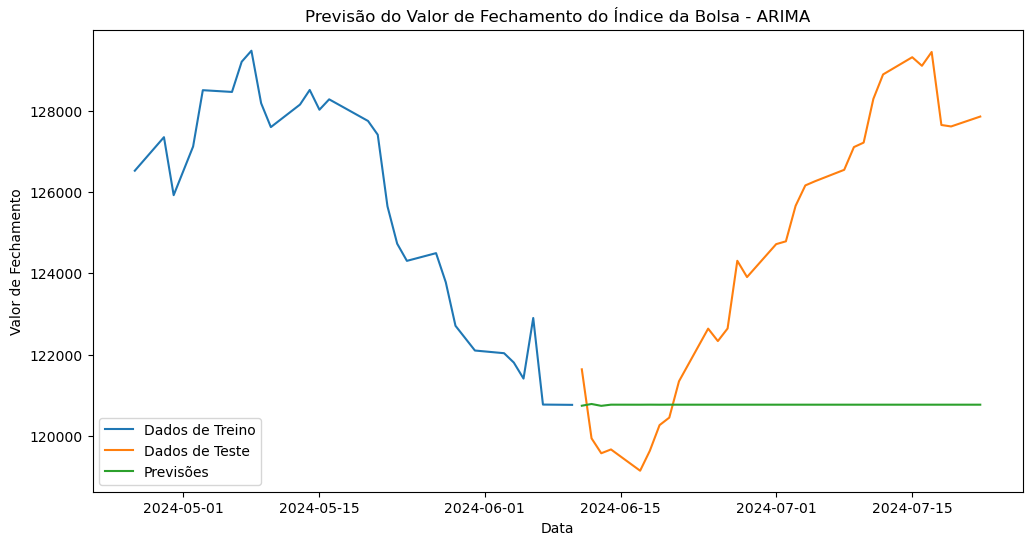

In [35]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(train_arima[-test_size:], label='Dados de Treino')
plt.plot(test_arima.index, test_arima, label='Dados de Teste')
plt.plot(test_arima.index, predict_arima, label='Previsões')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

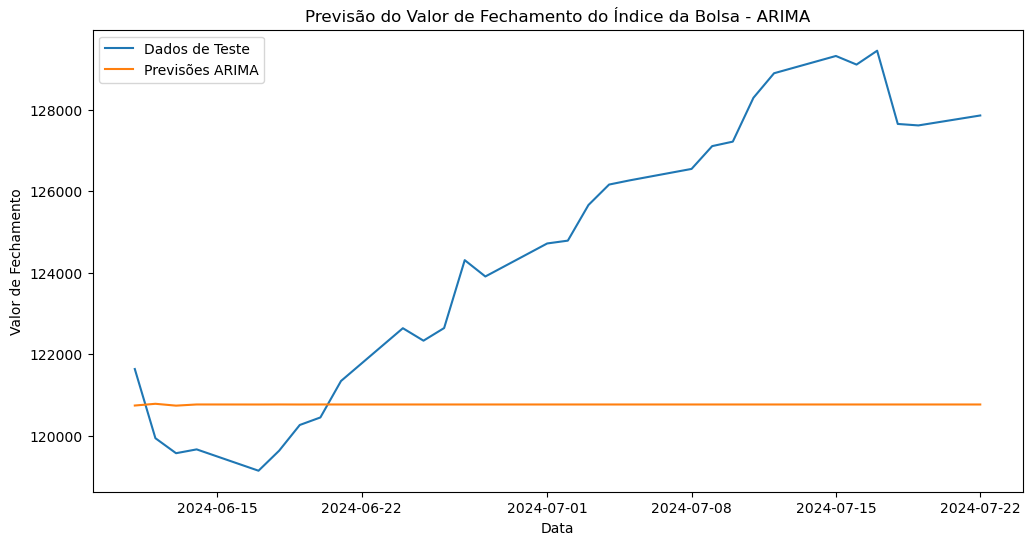

In [36]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_arima.index, test_arima, label='Dados de Teste')
plt.plot(test_arima.index, predict_arima, label='Previsões ARIMA')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [37]:
metrics_arima = calculate_metrics(test_arima.values, predict_arima)
print_metrics('ARIMA', metrics_arima)

ARIMA Metrics:
MAE: 4153.938842682058
MSE: 25237145.150328454
MAPE: 3.2794599690387027


### AutoARIMA

In [38]:
# Preparando dados de treino para AutoARIMA
train_autoarima = train.copy()
train_autoarima = train_autoarima.reset_index()
train_autoarima = train_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
train_autoarima['unique_id'] = 'Bolsa de Valores'
train_autoarima.tail()

ds       y  abertura         unique_id
714 2024-06-04  121802    122032  Bolsa de Valores
715 2024-06-05  121407    121803  Bolsa de Valores
716 2024-06-06  122899    121408  Bolsa de Valores
717 2024-06-07  120767    122899  Bolsa de Valores
718 2024-06-10  120760    120769  Bolsa de Valores

In [39]:
# Preparando dados de teste para AutoARIMA
test_autoarima = test.copy()
test_autoarima = test_autoarima.reset_index()
test_autoarima = test_autoarima.rename(columns={"data": "ds", "fechamento": "y"})
test_autoarima['unique_id'] = 'Bolsa de Valores'
test_autoarima.head()

ds       y  abertura         unique_id
0 2024-06-11  121635    120760  Bolsa de Valores
1 2024-06-12  119936    121644  Bolsa de Valores
2 2024-06-13  119568    119936  Bolsa de Valores
3 2024-06-14  119662    119558  Bolsa de Valores
4 2024-06-17  119138    119663  Bolsa de Valores

In [40]:
X_df_autorima = test_autoarima[['ds', 'abertura', 'unique_id']]
X_df_autorima.head()

ds  abertura         unique_id
0 2024-06-11    120760  Bolsa de Valores
1 2024-06-12    121644  Bolsa de Valores
2 2024-06-13    119936  Bolsa de Valores
3 2024-06-14    119558  Bolsa de Valores
4 2024-06-17    119663  Bolsa de Valores

In [41]:
model_autoarima = StatsForecast(models=[AutoARIMA(season_length=1)], freq='B',n_jobs=-1) # season_length=1 (sem sazonalidade) freq='B' (dias úteis - business days)
model_autoarima.fit(train_autoarima)
predict_autoarima = model_autoarima.predict(h=test_size, level = [90], X_df = X_df_autorima) # h=test_size, level=[90] (nível de confiança)
predict_autoarima.tail()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:492: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


ds      AutoARIMA  AutoARIMA-lo-90  AutoARIMA-hi-90
unique_id                                                                   
Bolsa de Valores 2024-07-16  120880.328125    109717.312500    132043.343750
Bolsa de Valores 2024-07-17  120877.375000    109501.710938    132253.046875
Bolsa de Valores 2024-07-18  120882.132812    109297.718750    132466.546875
Bolsa de Valores 2024-07-19  120856.835938    109067.375000    132646.296875
Bolsa de Valores 2024-07-22  120856.328125    108865.320312    132847.328125

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsforecast/core.py:1447: FutureWarning: Passing the ids as the index is deprecated. Please provide them as a column instead.
  warnings.warn(


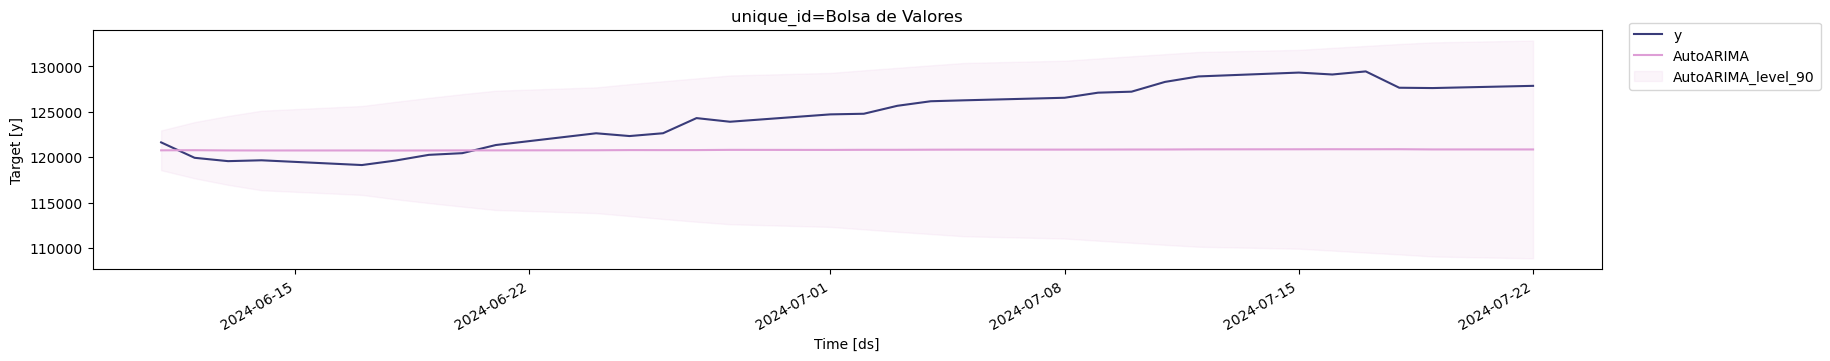

In [42]:
model_autoarima.plot(test_autoarima, predict_autoarima, level = [90], unique_ids = ['Bolsa de Valores'], engine = 'matplotlib')

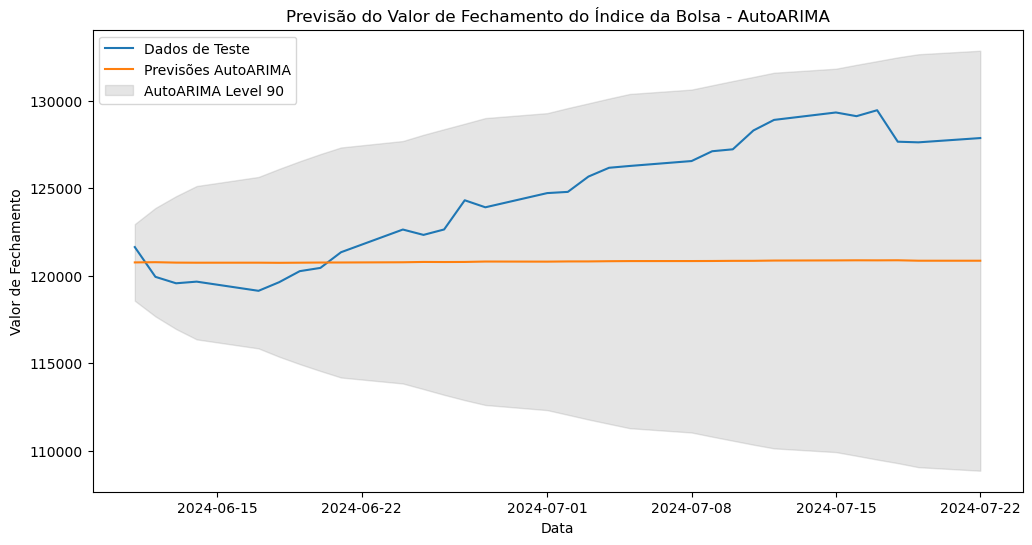

In [43]:
# Visualizando as previsões do modelo ARIMA
plt.figure(figsize=(12, 6))
plt.plot(test_autoarima['ds'], test_autoarima['y'], label='Dados de Teste')
plt.plot(predict_autoarima['ds'], predict_autoarima['AutoARIMA'], label='Previsões AutoARIMA')
plt.fill_between(predict_autoarima['ds'], predict_autoarima['AutoARIMA-lo-90'], predict_autoarima['AutoARIMA-hi-90'], color='gray', alpha=0.2, label='AutoARIMA Level 90')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - AutoARIMA')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='upper left')
plt.show()

In [44]:
metrics_autoarima = calculate_metrics(test_autoarima['y'].values, predict_autoarima['AutoARIMA'].values)
print_metrics('AutoARIMA', metrics_autoarima)

AutoARIMA Metrics:
MAE: 4101.737760416667
MSE: 24594597.6788798
MAPE: 3.2382882017005183


# ARIMA com Estacionariedade (pct_change)

Para obtermos melhores resultados com o modelo ARIMA, é interessante que os dados tenham estacionariedade.

Por isso, vamos manipular o dataset considerando retornos diários: o percentual de variação do preço em relação ao dia anterior.

$R(t) = p(t)/p(t-1) - 1$

Vamos realizar essa operação utilizando a função `pct_change` do Pandas e, então, testar a estacionariedade do resultado. 

In [45]:
df_stationarity_arima = df_modeling[['fechamento']].copy()
df_stationarity_arima = df_stationarity_arima.pct_change().dropna()
df_stationarity_arima

fechamento
data                  
2021-07-23   -0.008672
2021-07-26    0.007605
2021-07-27   -0.011047
2021-07-28    0.013434
2021-07-29   -0.004838
...                ...
2024-07-16   -0.001632
2024-07-17    0.002633
2024-07-18   -0.013890
2024-07-19   -0.000282
2024-07-22    0.001912

[748 rows x 1 columns]

<Axes: title={'center': 'Retornos diários do Preço de Fechamento da IBOVESPA'}, xlabel='data'>

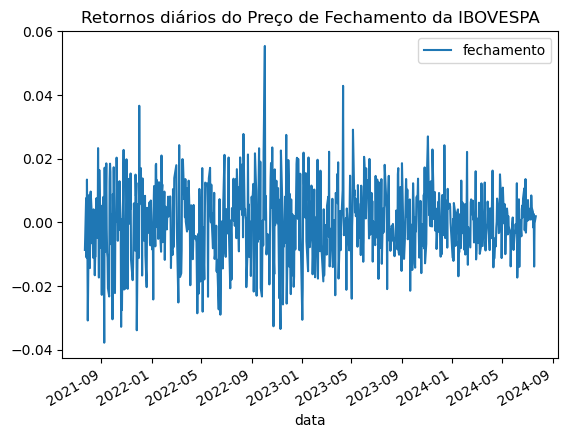

In [46]:
df_stationarity_arima.plot(title='Retornos diários do Preço de Fechamento da IBOVESPA')

In [47]:
# Teste de Dickey-Fuller
print('Resultados do Teste de Dickey-Fuller:')
df_adftest_pct_change = adfuller(df_stationarity_arima['fechamento'], autolag='AIC')
dfoutput = pd.Series(df_adftest_pct_change[0:4], index=['Estatística do Teste', 'Valor-p', 'Número de Lags Usados', 'Número de Observações Usadas'])
for key, value in df_adftest_pct_change[4].items():
    dfoutput['Valor Crítico (%s)' % key] = value
print(dfoutput)

# Verificar o valor-p e imprimir o resultado do teste de estacionariedade
if df_adftest_pct_change[1] > 0.05:
    print("H0 - HIPOTESE NULA (NÃO É ESTACIONÁRIA)")
else:
    print("H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)")

Resultados do Teste de Dickey-Fuller:
Estatística do Teste            -26.811004
Valor-p                           0.000000
Número de Lags Usados             0.000000
Número de Observações Usadas    747.000000
Valor Crítico (1%)               -3.439134
Valor Crítico (5%)               -2.865417
Valor Crítico (10%)              -2.568834
dtype: float64
H1 - HIPOTESE ALTERNATIVA (REJEIÇÃO DA HIPOTESE NULA, OU SEJA, É ESTACIONÁRIA)


In [48]:
train_pct = df_stationarity_arima[:train_size]
train_pct = train_pct.asfreq('B').fillna(0) # considerando variação 0 em feriados
train_pct.tail()

fechamento
data                  
2024-06-05   -0.003243
2024-06-06    0.012289
2024-06-07   -0.017348
2024-06-10   -0.000058
2024-06-11    0.007246

In [49]:
test_pct = df_stationarity_arima[train_size:]
test_pct = test_pct.asfreq('B').fillna(0) # considerando variação 0 em feriados
test_pct

fechamento
data                  
2024-06-12   -0.013968
2024-06-13   -0.003068
2024-06-14    0.000786
2024-06-17   -0.004379
2024-06-18    0.004130
2024-06-19    0.005275
2024-06-20    0.001538
2024-06-21    0.007431
2024-06-24    0.010681
2024-06-25   -0.002495
2024-06-26    0.002534
2024-06-27    0.013593
2024-06-28   -0.003226
2024-07-01    0.006545
2024-07-02    0.000553
2024-07-03    0.007012
2024-07-04    0.003995
2024-07-05    0.000816
2024-07-08    0.002225
2024-07-09    0.004425
2024-07-10    0.000865
2024-07-11    0.008458
2024-07-12    0.004700
2024-07-15    0.003289
2024-07-16   -0.001632
2024-07-17    0.002633
2024-07-18   -0.013890
2024-07-19   -0.000282
2024-07-22    0.001912

In [50]:
# Ajustando o modelo ARIMA
model_arima_pct = ARIMA(train_pct, order=(5, 1, 0))
model_arima_pct_fit = model_arima_pct.fit()

In [51]:
predict_arima_pct = model_arima_pct_fit.predict(start=len(train_pct), end=len(train_pct) + len(test_pct) - 1)
predict_arima_pct

2024-06-12   -0.000322
2024-06-13   -0.001065
2024-06-14    0.001759
2024-06-17   -0.002684
2024-06-18    0.000304
2024-06-19    0.001406
2024-06-20   -0.000041
2024-06-21   -0.000215
2024-06-24    0.000327
2024-06-25   -0.000331
2024-06-26    0.000168
2024-06-27    0.000321
2024-06-28    0.000050
2024-07-01    0.000021
2024-07-02    0.000127
2024-07-03    0.000030
2024-07-04    0.000110
2024-07-05    0.000128
2024-07-08    0.000079
2024-07-09    0.000076
2024-07-10    0.000097
2024-07-11    0.000082
2024-07-12    0.000094
2024-07-15    0.000096
2024-07-16    0.000087
2024-07-17    0.000087
2024-07-18    0.000091
2024-07-19    0.000089
2024-07-22    0.000091
Freq: B, Name: predicted_mean, dtype: float64

In [52]:
# Recuperando informações de preço a partir das variações previstas pelo modelo
recovered_predict_arima_pct = pd.Series(dtype='float64')
recovered_predict_arima_pct.loc[0] = test['fechamento'].iloc[0]  # Usando valor de teste já que valor não existe na previsão

for i in range(0, len(predict_arima_pct)):
    recovered_predict_arima_pct.loc[i+1] = recovered_predict_arima_pct.iloc[i-1] * (1 + predict_arima_pct.iloc[i])
    
recovered_predict_arima_pct

0     121635.000000
1     121595.840944
2     121505.421916
3     121809.767201
4     121179.320691
5     121846.770232
6     121349.756567
7     121841.781577
8     121323.720112
9     121881.592435
10    121283.597142
11    121902.058803
12    121322.490545
13    121908.169057
14    121324.987536
15    121923.633257
16    121328.587851
17    121936.990625
18    121344.161343
19    121946.658330
20    121353.344643
21    121958.429696
22    121363.284483
23    121969.906139
24    121374.935378
25    121980.567032
26    121385.526396
27    121991.701037
28    121396.327827
29    122002.770555
dtype: float64

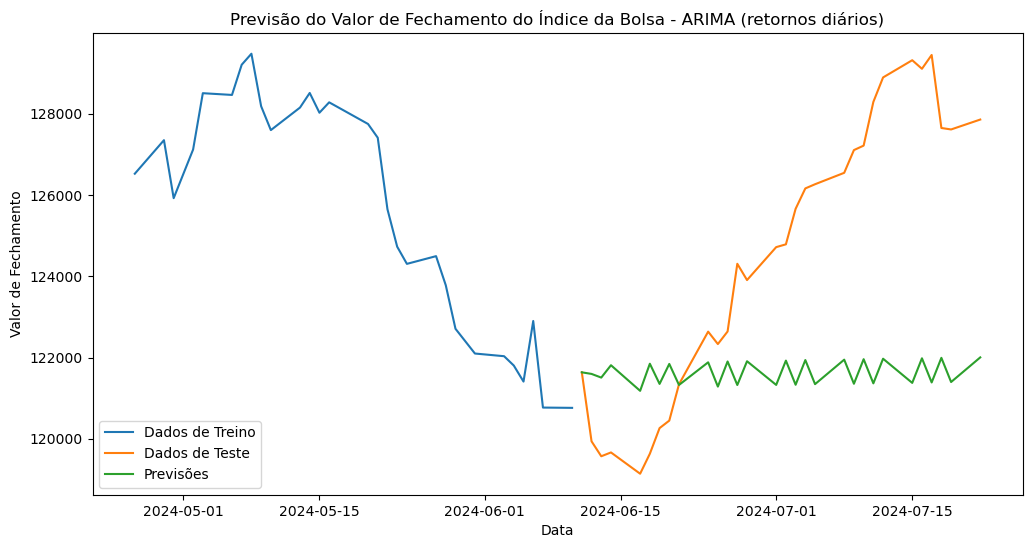

In [53]:
# Visualizando as previsões do modelo ARIMA (pct_change)
plt.figure(figsize=(12, 6))
plt.plot(train['fechamento'][-test_size:], label='Dados de Treino')
plt.plot(test_arima.index, test_arima['fechamento'], label='Dados de Teste')
plt.plot(test_arima.index, recovered_predict_arima_pct, label='Previsões')
plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - ARIMA (retornos diários)')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend()
plt.show()

In [54]:
metrics_arima_pct = calculate_metrics(test_arima.values, recovered_predict_arima_pct)
print_metrics('ARIMA PCT', metrics_arima_pct)

ARIMA PCT Metrics:
MAE: 3670.7072969572605
MSE: 19368551.07908559
MAPE: 2.9035171512136806


### Prophet

In [55]:
# Preparando dados de treino para o Prophet
train_prophet = train.copy()
train_prophet = train_prophet.reset_index()
train_prophet = train_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
train_prophet.head()

ds       y  abertura
0 2021-07-22  126147    125930
1 2021-07-23  125053    126140
2 2021-07-26  126004    125058
3 2021-07-27  124612    126004
4 2021-07-28  126286    124615

In [56]:
# Preparando dados de teste para o Prophet
test_prophet = test.copy()
test_prophet = test_prophet.reset_index()
test_prophet = test_prophet.rename(columns={'data': 'ds', 'fechamento': 'y'})
test_prophet

ds       y  abertura
0  2024-06-11  121635    120760
1  2024-06-12  119936    121644
2  2024-06-13  119568    119936
3  2024-06-14  119662    119558
4  2024-06-17  119138    119663
5  2024-06-18  119630    119138
6  2024-06-19  120261    119630
7  2024-06-20  120446    120267
8  2024-06-21  121341    120446
9  2024-06-24  122637    121343
10 2024-06-25  122331    122634
11 2024-06-26  122641    122331
12 2024-06-27  124308    122642
13 2024-06-28  123907    124308
14 2024-07-01  124718    123905
15 2024-07-02  124787    124720
16 2024-07-03  125662    124787
17 2024-07-04  126164    125666
18 2024-07-05  126267    126165
19 2024-07-08  126548    126280
20 2024-07-09  127108    126548
21 2024-07-10  127218    127109
22 2024-07-11  128294    127221
23 2024-07-12  128897    128293
24 2024-07-15  129321    128898
25 2024-07-16  129110    129322
26 2024-07-17  129450    129112
27 2024-07-18  127652    129450
28 2024-07-19  127616    127652
29 2024-07-22  127860    127616

In [57]:
model_prophet = Prophet(weekly_seasonality=False,
        yearly_seasonality=True,
        daily_seasonality=False)

model_prophet.add_country_holidays(country_name='BR')
model_prophet.add_regressor('abertura')

model_prophet.fit(train_prophet)

future_prophet= model_prophet.make_future_dataframe(periods=test_size, freq='B') # freq='B' (dias úteis - business days)
future_prophet['abertura'] = pd.concat([train_prophet['abertura'], test_prophet['abertura'], test_prophet['abertura']], ignore_index=True)

predict_prophet = model_prophet.predict(future_prophet)
predict_prophet.sort_values(by='ds')

15:33:51 - cmdstanpy - INFO - Chain [1] start processing
15:33:51 - cmdstanpy - INFO - Chain [1] done processing


ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2021-07-22  114154.809980  123773.724200  127127.159769  114154.809980   
1   2021-07-23  114153.264419  124180.509049  127345.673125  114153.264419   
2   2021-07-26  114148.627736  123056.120745  126284.215210  114148.627736   
3   2021-07-27  114147.082175  124023.371590  127223.368800  114147.082175   
4   2021-07-28  114145.536614  122639.997907  125954.314682  114145.536614   
..         ...            ...            ...            ...            ...   
744 2024-07-16  114760.831561  127588.130855  130937.853044  114746.008658   
745 2024-07-17  114760.788962  127174.515138  130726.708877  114744.971099   
746 2024-07-18  114760.746362  127652.161044  130987.909708  114743.856127   
747 2024-07-19  114760.703763  125817.746455  129262.393037  114742.621771   
748 2024-07-22  114760.575965  125970.845544  129358.383262  114740.572028   

       trend_upper  Confraternização Universal  \
0    114154.809980                         0.0   
1    114153.264419                         0.0   
2    114148.627736                         0.0   
3    114147.082175                         0.0   
4    114145.536614                         0.0   
..             ...                         ...   
744  114776.038440                         0.0   
745  114777.215352                         0.0   
746  114778.373569                         0.0   
747  114779.514270                         0.0   
748  114780.677698                         0.0   

     Confraternização Universal_lower  Confraternização Universal_upper  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   
..                                ...                               ...   
744                               0.0                               0.0   
745                               0.0                               0.0   
746                               0.0                               0.0   
747                               0.0                               0.0   
748                               0.0                               0.0   

     Dia Nacional de Zumbi e da Consciência Negra  ...  holidays  \
0                                             0.0  ...       0.0   
1                                             0.0  ...       0.0   
2                                             0.0  ...       0.0   
3                                             0.0  ...       0.0   
4                                             0.0  ...       0.0   
..                                            ...  ...       ...   
744                                           0.0  ...       0.0   
745                                           0.0  ...       0.0   
746                                           0.0  ...       0.0   
747                                           0.0  ...       0.0   
748                                           0.0  ...       0.0   

     holidays_lower  holidays_upper      yearly  yearly_lower  yearly_upper  \
0               0.0             0.0  164.476389    164.476389    164.476389   
1               0.0             0.0  186.011197    186.011197    186.011197   
2               0.0             0.0  226.975822    226.975822    226.975822   
3               0.0             0.0  232.844919    232.844919    232.844919   
4               0.0             0.0  235.091804    235.091804    235.091804   
..              ...             ...         ...           ...           ...   
744             0.0             0.0  -21.848615    -21.848615    -21.848615   
745             0.0             0.0   16.336869     16.336869     16.336869   
746             0.0             0.0   52.7129

In [58]:
model_prophet.train_holiday_names

0                      Confraternização Universal
1                               Sexta-feira Santa
2                                      Tiradentes
3                              Dia do Trabalhador
4                         Independência do Brasil
5                         Nossa Senhora Aparecida
6                                         Finados
7                        Proclamação da República
8    Dia Nacional de Zumbi e da Consciência Negra
9                                           Natal
dtype: object

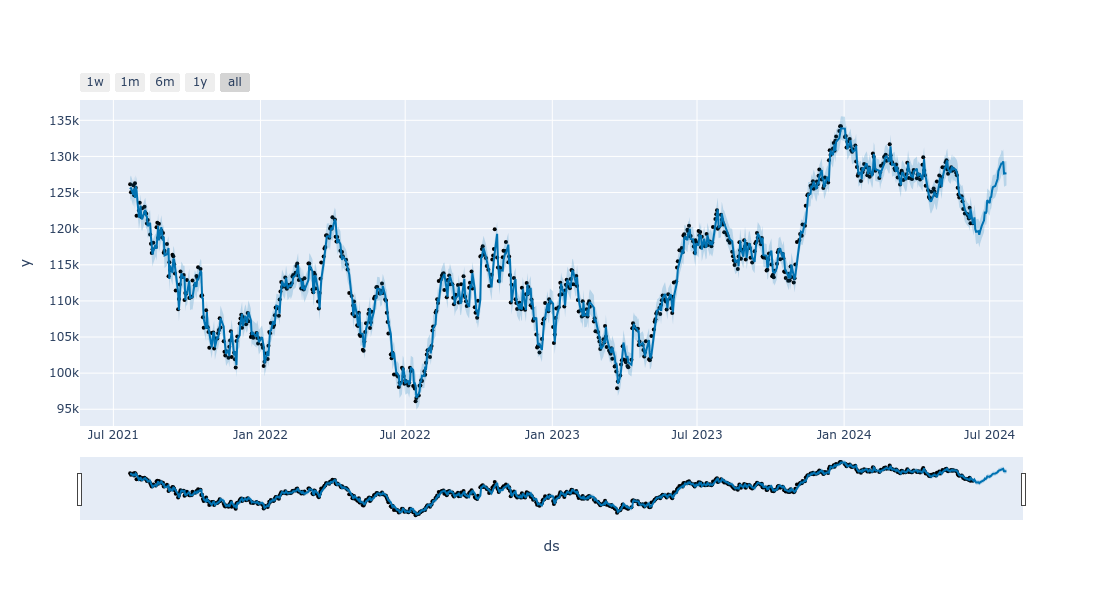

In [59]:
prophet_plot(model_prophet, predict_prophet)

In [60]:
predict_prophet_test = predict_prophet.tail(test_size)[['ds', 'yhat']].reset_index(drop=True)
predict_prophet_test.tail()

ds           yhat
25 2024-07-16  129125.183944
26 2024-07-17  128962.075586
27 2024-07-18  129322.327708
28 2024-07-19  127633.211276
29 2024-07-22  127682.069863

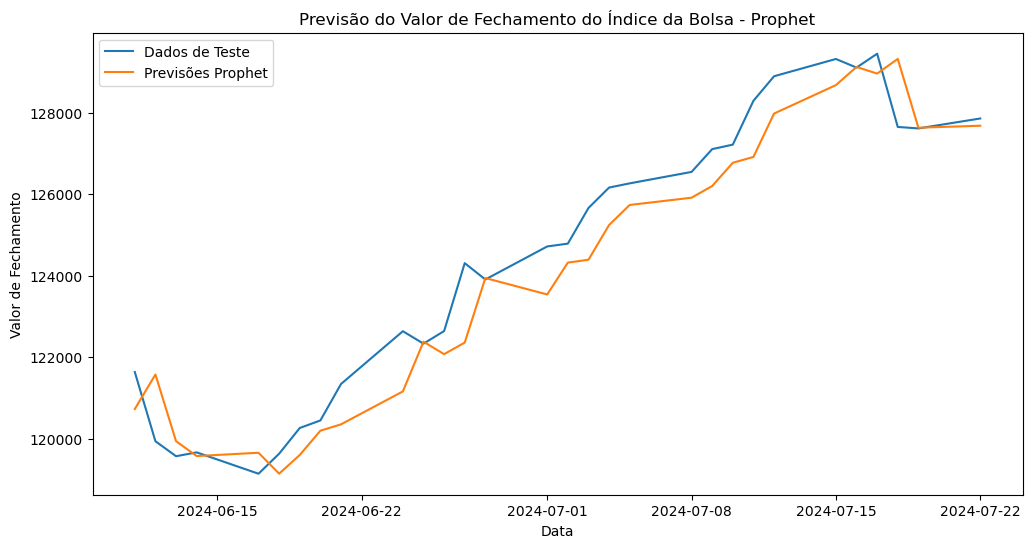

In [61]:
# Visualizando as previsões do modelo Prophet
plt.figure(figsize=(12, 6))
plt.plot(test_prophet['ds'], test_prophet['y'], label='Dados de Teste')
plt.plot(predict_prophet_test['ds'], predict_prophet_test['yhat'], label='Previsões Prophet')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - Prophet')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [62]:
metrics_prophet = calculate_metrics(test_prophet['y'].values, predict_prophet_test['yhat'].values)
print_metrics('Prophet', metrics_prophet)

Prophet Metrics:
MAE: 721.726602776514
MSE: 797992.2703369397
MAPE: 0.5798129867462333


#### Testando Possível Overfitting do Prophet

In [63]:
# Filtrar previsões para o período de treinamento
predict_prophet_train = predict_prophet[predict_prophet['ds'] < '2024-06-11']
predict_prophet_train

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2021-07-22  114154.809980  123773.724200  127127.159769  114154.809980   
1   2021-07-23  114153.264419  124180.509049  127345.673125  114153.264419   
2   2021-07-26  114148.627736  123056.120745  126284.215210  114148.627736   
3   2021-07-27  114147.082175  124023.371590  127223.368800  114147.082175   
4   2021-07-28  114145.536614  122639.997907  125954.314682  114145.536614   
..         ...            ...            ...            ...            ...   
714 2024-06-04  114762.620733  120386.617214  123531.891506  114762.620733   
715 2024-06-05  114762.578134  120198.595531  123418.178451  114762.578134   
716 2024-06-06  114762.535535  119677.516411  123000.992273  114762.535535   
717 2024-06-07  114762.492935  121158.325450  124425.689812  114762.492935   
718 2024-06-10  114762.365137  119117.860061  122348.496856  114762.365137   

       trend_upper  Confraternização Universal  \
0    114154.809980                         0.0   
1    114153.264419                         0.0   
2    114148.627736                         0.0   
3    114147.082175                         0.0   
4    114145.536614                         0.0   
..             ...                         ...   
714  114762.620733                         0.0   
715  114762.578134                         0.0   
716  114762.535535                         0.0   
717  114762.492935                         0.0   
718  114762.365137                         0.0   

     Confraternização Universal_lower  Confraternização Universal_upper  \
0                                 0.0                               0.0   
1                                 0.0                               0.0   
2                                 0.0                               0.0   
3                                 0.0                               0.0   
4                                 0.0                               0.0   
..                                ...                               ...   
714                               0.0                               0.0   
715                               0.0                               0.0   
716                               0.0                               0.0   
717                               0.0                               0.0   
718                               0.0                               0.0   

     Dia Nacional de Zumbi e da Consciência Negra  ...  holidays  \
0                                             0.0  ...       0.0   
1                                             0.0  ...       0.0   
2                                             0.0  ...       0.0   
3                                             0.0  ...       0.0   
4                                             0.0  ...       0.0   
..                                            ...  ...       ...   
714                                           0.0  ...       0.0   
715                                           0.0  ...       0.0   
716                                           0.0  ...       0.0   
717                                           0.0  ...       0.0   
718                                           0.0  ...       0.0   

     holidays_lower  holidays_upper      yearly  yearly_lower  yearly_upper  \
0               0.0             0.0  164.476389    164.476389    164.476389   
1               0.0             0.0  186.011197    186.011197    186.011197   
2               0.0             0.0  226.975822    226.975822    226.975822   
3               0.0             0.0  232.844919    232.844919    232.844919   
4               0.0             0.0  235.091804    235.091804    235.091804   
..              ...             ...         ...           ...           ...   
714             0.0             0.0 -224.411707   -224.411707   -224.411707   
715             0.0             0.0 -226.512648   -226.512648   -226.512648   
716             0.0             0.0 -226.7536

In [64]:
# Supondo que você tenha previsões para treinamento e teste
mape_train = calculate_metrics(train_prophet['y'], predict_prophet_train['yhat'])[2]
mape_test = calculate_metrics(test_prophet['y'], predict_prophet_test['yhat'])[2]

print(f"MAPE nos Dados de Treinamento: {mape_train:.2f}%")
print(f"MAPE nos Dados de Teste: {mape_test:.2f}%")

MAPE nos Dados de Treinamento: 0.90%
MAPE nos Dados de Teste: 0.58%


#### Conclusão

O fato de o MAPE nos dados de teste ser menor do que nos dados de treinamento não é comum e **não é um sinal típico de overfitting**. 


Overfitting geralmente é indicado por um MAPE muito baixo em dados de treinamento e um MAPE significativamente maior em dados de teste. Nesse caso, o MAPE em dados de teste é menor, o que pode indicar que o modelo está generalizando bem e, possivelmente, foi ajustado de forma robusta.

### XGBoost

In [65]:
# Preparando dados de treino para o XGBoost
train_xgb = train.copy()
train_xgb = train_xgb.reset_index()
train_xgb['ano'] = train_xgb['data'].dt.year
train_xgb['mes'] = train_xgb['data'].dt.month
train_xgb['dia'] = train_xgb['data'].dt.day
train_xgb['diadasemana'] = train_xgb['data'].dt.dayofweek
train_xgb.tail()

data  fechamento  abertura   ano  mes  dia  diadasemana
714 2024-06-04      121802    122032  2024    6    4            1
715 2024-06-05      121407    121803  2024    6    5            2
716 2024-06-06      122899    121408  2024    6    6            3
717 2024-06-07      120767    122899  2024    6    7            4
718 2024-06-10      120760    120769  2024    6   10            0

In [66]:
# Preparando dados de treino para o XGBoost
test_xgb = test.copy()
test_xgb = test_xgb.reset_index()
test_xgb['ano'] = test_xgb['data'].dt.year
test_xgb['mes'] = test_xgb['data'].dt.month
test_xgb['dia'] = test_xgb['data'].dt.day
test_xgb['diadasemana'] = test_xgb['data'].dt.dayofweek
test_xgb

data  fechamento  abertura   ano  mes  dia  diadasemana
0  2024-06-11      121635    120760  2024    6   11            1
1  2024-06-12      119936    121644  2024    6   12            2
2  2024-06-13      119568    119936  2024    6   13            3
3  2024-06-14      119662    119558  2024    6   14            4
4  2024-06-17      119138    119663  2024    6   17            0
5  2024-06-18      119630    119138  2024    6   18            1
6  2024-06-19      120261    119630  2024    6   19            2
7  2024-06-20      120446    120267  2024    6   20            3
8  2024-06-21      121341    120446  2024    6   21            4
9  2024-06-24      122637    121343  2024    6   24            0
10 2024-06-25      122331    122634  2024    6   25            1
11 2024-06-26      122641    122331  2024    6   26            2
12 2024-06-27      124308    122642  2024    6   27            3
13 2024-06-28      123907    124308  2024    6   28            4
14 2024-07-01      124718    123905  2024    7    1            0
15 2024-07-02      124787    124720  2024    7    2            1
16 2024-07-03      125662    124787  2024    7    3            2
17 2024-07-04      126164    125666  2024    7    4            3
18 2024-07-05      126267    126165  2024    7    5            4
19 2024-07-08      126548    126280  2024    7    8            0
20 2024-07-09      127108    126548  2024    7    9            1
21 2024-07-10      127218    127109  2024    7   10            2
22 2024-07-11      128294    127221  2024    7   11            3
23 2024-07-12      128897    128293  2024    7   12            4
24 2024-07-15      129321    128898  2024    7   15            0
25 2024-07-16      129110    129322  2024    7   16            1
26 2024-07-17      129450    129112  2024    7   17            2
27 2024-07-18      127652    129450  2024    7   18            3
28 2024-07-19      127616    127652  2024    7   19            4
29 2024-07-22      127860    127616  2024    7   22            0

In [67]:
FEATURES = ['ano', 'mes', 'dia', 'diadasemana', 'abertura']
TARGET = 'fechamento'

X_train_xgb, y_train_xgb = train_xgb[FEATURES], train_xgb[TARGET]
X_test_xgb, y_test_xgb = test_xgb[FEATURES], test_xgb[TARGET]

reg = xgb.XGBRegressor(objective='reg:squarederror')
reg.fit(X_train_xgb, y_train_xgb)

# Avaliação XGBoost
predict_xgb = reg.predict(X_test_xgb)
predict_xgb

array([120656.85 , 122282.375, 119784.5  , 118682.95 , 119775.12 ,
       118460.1  , 120170.164, 120535.5  , 120021.79 , 121797.016,
       121842.94 , 122042.516, 121005.03 , 124313.055, 124648.62 ,
       125615.26 , 125985.3  , 125697.06 , 127000.44 , 127798.68 ,
       128489.32 , 126993.195, 126914.4  , 127750.23 , 129190.14 ,
       129230.49 , 128783.13 , 128282.58 , 127290.42 , 126997.97 ],
      dtype=float32)

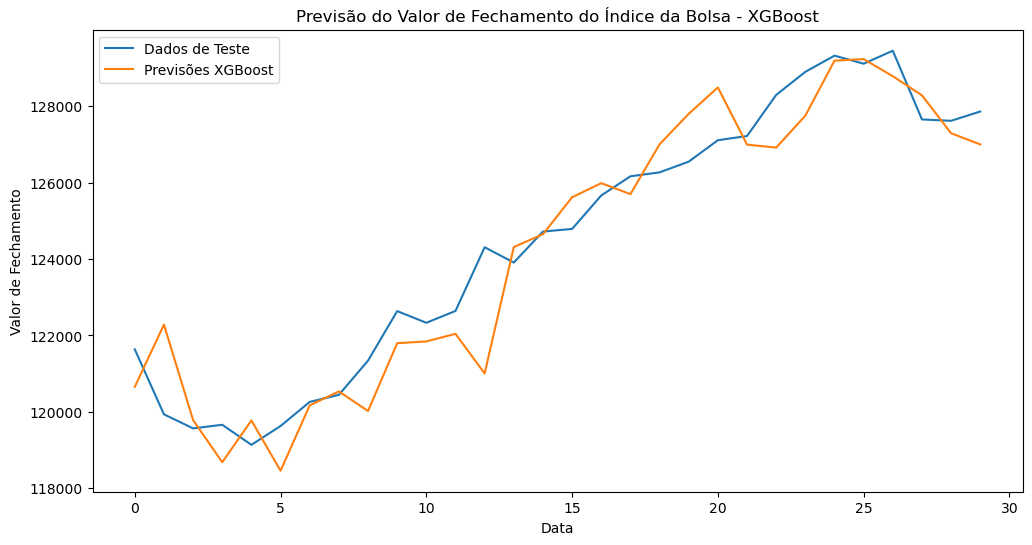

In [68]:
# Visualizando as previsões do modelo XGBoost
plt.figure(figsize=(12, 6))
plt.plot(X_test_xgb.index, y_test_xgb, label='Dados de Teste')
plt.plot(X_test_xgb.index, predict_xgb, label='Previsões XGBoost')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - XGBoost')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [69]:
metrics_xgb = calculate_metrics(y_test_xgb, predict_xgb)
print_metrics('XGBoost', metrics_xgb)

XGBoost Metrics:
MAE: 800.1028645833334
MSE: 1113027.3837137858
MAPE: 0.6447850369191079


### SARIMAX

In [70]:
# Preparando dados de treino para SARIMAX
train_sarimax = train[['fechamento']].copy()
train_sarimax.tail()

fechamento
data                  
2024-06-04      121802
2024-06-05      121407
2024-06-06      122899
2024-06-07      120767
2024-06-10      120760

In [71]:
# Preparando dados exógenos de treino para SARIMAX
exog_train_sarimax = train[['abertura']].copy()
exog_train_sarimax.tail()

abertura
data                
2024-06-04    122032
2024-06-05    121803
2024-06-06    121408
2024-06-07    122899
2024-06-10    120769

In [72]:
# Preparando dados de teste para SARIMAX
test_sarimax = test[['fechamento']].copy()
test_sarimax.tail()

fechamento
data                  
2024-07-16      129110
2024-07-17      129450
2024-07-18      127652
2024-07-19      127616
2024-07-22      127860

In [73]:
# Preparando dados exógenos de teste para SARIMAX
exog_test_sarimax = test[['abertura']].copy()
exog_test_sarimax.tail()

abertura
data                
2024-07-16    129322
2024-07-17    129112
2024-07-18    129450
2024-07-19    127652
2024-07-22    127616

In [74]:
model_sarimax = SARIMAX(train_sarimax, exog=exog_train_sarimax, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarimax = model_sarimax.fit()

predict_sarimax = fit_sarimax.get_forecast(steps=len(test_sarimax), exog=exog_test_sarimax).predicted_mean

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00021D+00    |proj g|=  1.24238D+00

At iterate    5    f=  8.70860D+00    |proj g|=  4.81357D-02

At iterate   10    f=  8.68735D+00    |proj g|=  1.66049D-01

At iterate   15    f=  8.60731D+00    |proj g|=  6.25534D-02

At iterate   20    f=  8.57756D+00    |proj g|=  3.78519D-02

At iterate   25    f=  8.57564D+00    |proj g|=  2.32940D-03

At iterate   30    f=  8.57418D+00    |proj g|=  1.23786D-02

At iterate   35    f=  8.57366D+00    |proj g|=  1.03076D-03

At iterate   40    f=  8.57364D+00    |proj g|=  1.24926D-03

At iterate   45    f=  8.57361D+00    |proj g|=  1.27136D-02

At iterate   50    f=  8.57217D+00    |proj g|=  6.80762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



#### Warning: falta de frequency information nos índices no SARIMAX

De maneira semelhante ao o modelo ARIMA, o modelo SARIMAX da biblioteca _statsmodels_ apresenta o seguinte warning:

> ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

Ignoramos esse warning porque, assim como no ARIMA, tivemos problemas com dias de feriado ao definirmos frequência de dias úteis (`B`, _business days_) no `DateTimeIndex` de treino.

In [75]:
predict_sarimax

719    120816.779944
720    121572.656408
721    120091.641899
722    119565.008537
723    119892.579191
724    119272.129035
725    119627.090389
726    120463.364340
727    120477.558248
728    121363.842450
729    122738.666402
730    122408.129399
731    122631.043960
732    124191.422813
733    124016.909911
734    124632.687715
735    124895.839673
736    125686.201937
737    126078.289119
738    126382.518197
739    126484.232272
740    127125.000078
741    127166.969234
742    128290.508894
743    128810.377024
744    129143.693714
745    129158.766991
746    129305.450946
747    127729.522321
748    127615.834904
Name: predicted_mean, dtype: float64

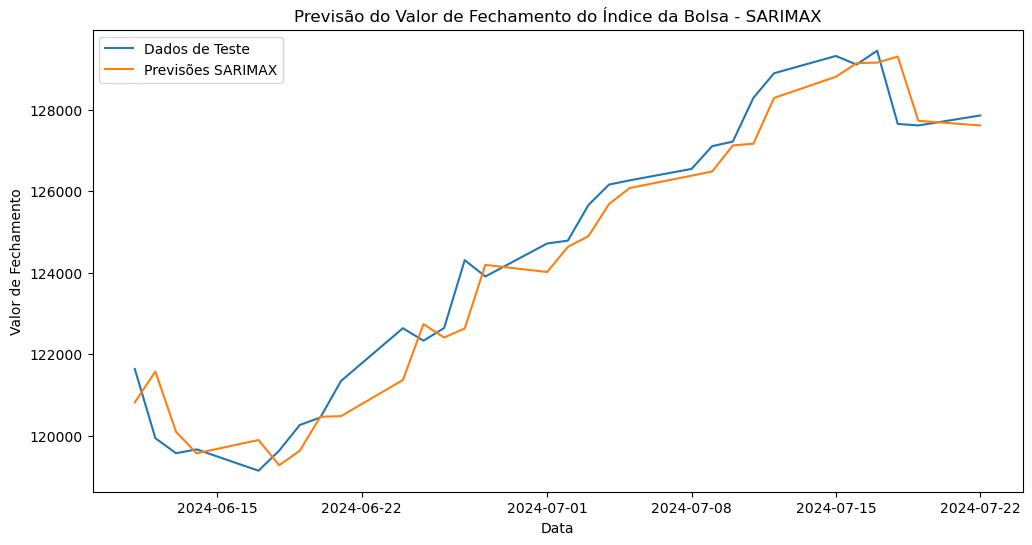

In [76]:
# Visualizando as previsões do modelo SARIMAX
plt.figure(figsize=(12, 6))
plt.plot(test_sarimax.index, test_sarimax['fechamento'], label='Dados de Teste')
plt.plot(test_sarimax.index, predict_sarimax, label='Previsões SARIMAX')

plt.title('Previsão do Valor de Fechamento do Índice da Bolsa - SARIMAX')
plt.xlabel('Data')
plt.ylabel('Valor de Fechamento')
plt.legend(loc='best')
plt.show()

In [77]:
metrics_sarimax = calculate_metrics(test_sarimax['fechamento'].values, predict_sarimax)
print_metrics('SARIMAX', metrics_sarimax)

SARIMAX Metrics:
MAE: 577.6093374020696
MSE: 559792.865902145
MAPE: 0.4656723272172326


## Passo 4: Comparando os modelos

In [78]:
df_metrics = pd.DataFrame(
    [metrics_arima, metrics_autoarima, metrics_arima_pct, metrics_prophet, metrics_xgb, metrics_sarimax],
    columns=['MAE', 'MSE', 'MAPE'],
    index=['ARIMA', 'AutoARIMA', 'ARIMA PCT', 'Prophet', 'XGBoost', 'SARIMAX'],
)
df_metrics

MAE           MSE      MAPE
ARIMA      4153.938843  2.523715e+07  3.279460
AutoARIMA  4101.737760  2.459460e+07  3.238288
ARIMA PCT  3670.707297  1.936855e+07  2.903517
Prophet     721.726603  7.979923e+05  0.579813
XGBoost     800.102865  1.113027e+06  0.644785
SARIMAX     577.609337  5.597929e+05  0.465672

#### Conclusão

Por meio das métricas de avaliação mostradas acima, podemos concluir que o modelo com menor erro seria o **SARIMAX**.

Por isso, vamos considerar todos os dados disponíveis para retreinar o modelo, considerando o próximo dia (23/07/2024).

Temos o dado de abertura do dia 23/07/2024, cujo valor é: `127860`. Vamos considerá-lo como dado exógeno para a nossa previsão.

In [79]:
# Preparando dados de treino para SARIMAX considerando todos os dados disponíveis
train_sarimax_next_day = df_modeling[['fechamento']].copy()
train_sarimax_next_day.tail()

fechamento
data                  
2024-07-16      129110
2024-07-17      129450
2024-07-18      127652
2024-07-19      127616
2024-07-22      127860

In [80]:
# Preparando dados exógenos de treino para SARIMAX considerando todos os dados disponíveis
exog_train_sarimax_next_day = df_modeling[['abertura']].copy()
exog_train_sarimax_next_day.tail()

abertura
data                
2024-07-16    129322
2024-07-17    129112
2024-07-18    129450
2024-07-19    127652
2024-07-22    127616

In [81]:
# Dado da abertura do dia 23/07/2024
open_next_day = 127860 # from https://br.investing.com/indices/bovespa-historical-data

In [82]:
model_sarimax_next_day = SARIMAX(train_sarimax_next_day, exog=exog_train_sarimax_next_day, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
fit_sarimax_next_day = model_sarimax_next_day.fit()

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97447D+00    |proj g|=  1.19348D+00


 This problem is unconstrained.



At iterate    5    f=  8.69877D+00    |proj g|=  4.99962D-02

At iterate   10    f=  8.67641D+00    |proj g|=  1.85550D-01

At iterate   15    f=  8.58156D+00    |proj g|=  6.40909D-02

At iterate   20    f=  8.56785D+00    |proj g|=  1.75018D-02

At iterate   25    f=  8.56698D+00    |proj g|=  4.17899D-03

At iterate   30    f=  8.56454D+00    |proj g|=  7.26075D-03

At iterate   35    f=  8.56448D+00    |proj g|=  2.43728D-03

At iterate   40    f=  8.55960D+00    |proj g|=  8.09698D-02

At iterate   45    f=  8.50656D+00    |proj g|=  4.95645D-01

At iterate   50    f=  8.47347D+00    |proj g|=  1.32531D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [83]:
predict_sarimax_next_day = fit_sarimax_next_day.get_forecast(steps=1, exog=[open_next_day]).predicted_mean
predict_sarimax_next_day

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/home/alexandre/miniconda3/envs/pydata-book/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



749    127842.978234
dtype: float64

In [84]:
predict_close_next_day_sarimax = predict_sarimax_next_day.iloc[-1]
predict_close_next_day_sarimax

127842.97823412197

In [85]:
actual_close_previous_day = df_modeling['fechamento'].iloc[-1]
actual_close_previous_day

127860

In [86]:
predict_pct_change_next_day_sarimax = (predict_close_next_day_sarimax/actual_close_previous_day) - 1
predict_pct_change_next_day_sarimax * 100

-0.013312815484145535

In [87]:
# Dado histórico real de fechamento para o dia 23/07/2024
actual_close_next_day = 126590 # from https://br.investing.com/indices/bovespa-historical-data

In [88]:
actual_pct_change_next_day = (actual_close_next_day/actual_close_previous_day) - 1
actual_pct_change_next_day * 100

-0.9932738933208229

In [89]:
error_next_day_sarimax = (actual_close_next_day/predict_close_next_day_sarimax) - 1
error_next_day_sarimax * 100

-0.9800915556170464

#### Análise dos Resultados
O modelo SARIMAX utilizado, com dados de treino de 3 anos (22/07/2021 a 22/07/2024), utilizando fechamento como _target_ e abertura como dado exógeno, previu um valor de fechamento para o dia 23/07/2024 de `127842.97823412197`. Considerando o dia anterior, seria uma baixa de 
`0.013`%.

Entretanto, o dado histórico real de fechamento da IBOVESPA para o dia 23/07/2024 foi de `126590`. Houve uma baixa de `-0.993`% em relação ao dia anterior. A direção da previsão, de queda, foi correta porém houve uma maior magnetude na data em questão (23/07/2024).

Entre os motivos da queda de quase 1% na IBOVESPA no dia 23/07/2024, está a desvalorização da Vale (VALE3), impulsionada por contratos futuros de minário de ferro e fraca demanda da China, segunda a revista Exame [1]. Portanto, são fatores exógenos de difícil modelagem.

[1]: https://exame.com/invest/mercados/ibovespa-hoje-23-07-2024/